# MNSIT-Sequential模板

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.datasets as dset
import torchvision.transforms as T
import numpy as np
%matplotlib inline

# 载入数据

In [2]:
set_train = dset.MNIST('./MNIST', train=True, transform=T.ToTensor(), download=True)
loader_train = DataLoader(set_train, batch_size=64)
set_test = dset.MNIST('./MNIST', train=False, transform=T.ToTensor(),download=True)
loader_test = DataLoader(set_test, batch_size=64)

print("训练集大小：",set_train.train_data.size())
print("训练集标签：",set_train.train_labels.size())
print("测试集大小：",set_test.test_data.size())
print("测试集标签：",set_test.test_labels.size())
type(set_train[0]) #数据集的索引是tuple

训练集大小： torch.Size([60000, 28, 28])
训练集标签： torch.Size([60000])
测试集大小： torch.Size([10000, 28, 28])
测试集标签： torch.Size([10000])


tuple

# 显示MNIST数据集图像

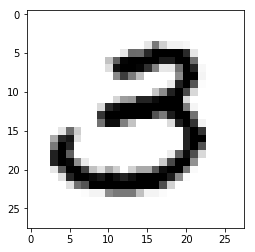

In [3]:
i=np.random.randint(0,60000) #随机数
img1 = set_train.train_data[i].numpy()
plt.imshow(img1,cmap="binary")

# 初始化一些参数

In [21]:
# 打印loss的频率
print_every = 100

# This is a little utility that we'll use to reset the model
# if we want to re-initialize all our parameters
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()
    
def train(model, loss_fn, optimizer, num_epochs = 1):
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        check_accuracy(model, loader_test)
        model.train()
        for t, (x, y) in enumerate(loader_train):
            x_var = Variable(x.cuda())
            y_var = Variable(y.cuda().long())
            scores = model(x_var)
            loss = loss_fn(scores, y_var)
            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss.data[0]))
                   
            optimizer.zero_grad()
            loss.backward()
            scheduler.step(loss.cpu().data.numpy()[0])
            optimizer.step()
def check_accuracy(model, loader):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for x, y in loader:
        x_var = Variable(x.cuda(), volatile=True)

        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

# 构造模型Net_test01
该网络接近LeNet，用标准写法，没有bn，用来试验用

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1), #conv1
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2), #pool1
            nn.Conv2d(16, 32, kernel_size=3, stride=1,padding=0), #conv2
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2), #pool2
        )
        self.classifier = nn.Sequential( 
            nn.Linear(1152, 400),                    
            nn.ReLU(inplace=True),
            nn.Linear(400, 200),                    
            nn.ReLU(inplace=True),
            nn.Linear(200, 100),                    
            nn.ReLU(inplace=True),
            nn.Linear(100, 10),                   
            )
        
    def forward(self,x):
        x = self.features(x)
        x = x.view(x.size(0),-1)
        x = self.classifier(x)
        return x
   
        

net = Net() #实例化模型
net.cuda()

x = torch.randn(64, 1, 28, 28) #测试模型是否架构数据
x = x.cuda()
x_var = Variable(x) # 变量化
ans = net(x_var)        # 喂入模型

# 应该相等
print(ans.size())
np.array_equal(np.array(ans.size()), np.array([64, 10]))

torch.Size([64, 10])


True

# 训练

In [24]:
loss_fn = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5, verbose=True)

net.apply(reset) #重置权值
train(net, loss_fn, optimizer, num_epochs=5)
check_accuracy(net, loader_test)

Starting epoch 1 / 5
Checking accuracy on test set
Got 910 / 10000 correct (9.10)
t = 100, loss = 0.2882
t = 200, loss = 0.3022
t = 300, loss = 0.1686
t = 400, loss = 0.1735
t = 500, loss = 0.2092
t = 600, loss = 0.2578
t = 700, loss = 0.1427
t = 800, loss = 0.1957
t = 900, loss = 0.0490
Starting epoch 2 / 5
Checking accuracy on test set
Got 9726 / 10000 correct (97.26)
t = 100, loss = 0.0368
t = 200, loss = 0.1013
t = 300, loss = 0.0273
t = 400, loss = 0.1604
t = 500, loss = 0.1054
t = 600, loss = 0.0341
t = 700, loss = 0.0828
t = 800, loss = 0.0290
t = 900, loss = 0.0430
Starting epoch 3 / 5
Checking accuracy on test set
Got 9863 / 10000 correct (98.63)
t = 100, loss = 0.0094
t = 200, loss = 0.0251
t = 300, loss = 0.0223
t = 400, loss = 0.1741
t = 500, loss = 0.0495
t = 600, loss = 0.0313
t = 700, loss = 0.0203
t = 800, loss = 0.0040
t = 900, loss = 0.0069
Starting epoch 4 / 5
Checking accuracy on test set
Got 9850 / 10000 correct (98.50)
t = 100, loss = 0.0072
t = 200, loss = 0.0038

# 可视化预测

根据图像预测的数字： [[8]]


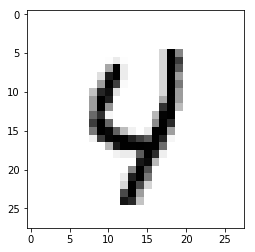

In [10]:
dtype = torch.cuda.FloatTensor#设置数据类型，cuda是gpu版
i = np.random.randint(0,60000) #随机数
x = set_train.train_data[i].view([1,1,28,28])
x_var = Variable(x.type(dtype))
img1 = set_train.train_data[i].numpy()
plt.imshow(img1,cmap="binary")
scores = net(x_var) #结果scores是个var
s, i = scores.data.cpu().max(1) #取var的data，放入cpu，计算最大的索引i和分数s
print("根据图像预测的数字：",i.numpy())

In [2]:
torch.save(net,"net_s.pkl")

NameError: name 'net' is not defined

In [6]:
net2 = torch.load("net_s.pkl")